In [2]:
# Conor Igoe --- October 2020
import torch
import torch.nn as nn
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch.optim as optim
from gym import spaces, logger
from gym.utils import seeding
from torch.utils.tensorboard import SummaryWriter
import datetime
import time
import pickle

In [3]:
class BanditEnv(gym.Env):
    '''
    Toy env to test your implementation
    The state is fixed (bandit setup)
    Action space: gym.spaces.Discrete(10)
    Note that the action takes integer values
    '''
    def __init__(self):
        self.action_space = gym.spaces.Discrete(10)
        self.observation_space = gym.spaces.Box(low=np.array([-1]), high=np.array([1]), dtype=np.float32)

    def reset(self):
        return np.array([0])

    def step(self, action):
        assert int(action) in self.action_space

        done = True
        s = np.array([0])
        r = -(action - 7)**2
        info = {}
        return s, r, done, info

In [4]:
class Policy(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Policy, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, num_actions),
            nn.Softmax(dim=0)
        )

        self.layers.apply(self.init_weights)
        
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        
    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight.data)
        
    def forward(self, x):
        return self.layers(torch.from_numpy(np.asarray(x)).float())

    def act(self, state):
        actions = list(range(int(self.num_actions)))
        probabilities = self.forward(state)        
        act = np.random.choice(actions, p=probabilities.detach().numpy())
        return act

In [ ]:
class ValueFunction(nn.Module):
    def __init__(self, num_inputs):
        super(ValueFunction, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        self.num_inputs = num_inputs

    def forward(self, x):
        return self.layers(torch.from_numpy(np.asarray(x)).float())

# HW3-P2 "REINFORCE" on BanditEnv

In [5]:
NUM_ITERATIONS = 15000
NUM_EVALUATION_ROLLOUTS = 100
EVALUATION_PERIOD = 100

GAMMA = 0.99

LEARNING_RATE = .0001

In [6]:
random.seed(17)
np.random.seed(17)
torch.manual_seed(17)

env = BanditEnv()
env.action_space.seed(17)
env.seed(17)

/Users/conor/opt/anaconda3/envs/DRL_HW3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
performance = np.zeros((NUM_EVALUATION_ROLLOUTS,math.ceil(NUM_ITERATIONS/EVALUATION_PERIOD)))
pi = Policy(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(pi.parameters(),lr=LEARNING_RATE)

now = datetime.datetime.now()
writer = SummaryWriter("runs/scalar-{}".format(now.strftime("%Y%m%d-%H%M%S")))

# 1 iteration == deploying a fixed stationary stochastic policy in the environment for 1 rollout until 
# termination and then using the collected data from that rollout to perform 1 policy gradient update
for iteration in range(NUM_ITERATIONS):
    history = []
    done = False
    state = env.reset()
    
    while not done: 
        action = pi.act(state)
        next_state, reward, done, info = env.step(action)
        history.append([state, action, reward, next_state, done])
        state = next_state

    # Sweep backwards through the collected data and use sample_return to accumulate the rewards 
    # to form the Monte Carlo estimates of the returns
    sample_return = 0
    loss = 0
    optimizer.zero_grad()
    
    for entry in reversed(history):
        state, action, reward, next_state, done = entry
        sample_return = reward + (GAMMA * sample_return)
        loss -= torch.log(pi(state)[action])*(sample_return) / len(history)
    
    # Take a policy gradient step
    loss.backward()
    optimizer.step()

    # Evaluate current policy occasionaly
    if iteration % EVALUATION_PERIOD == 0:
        evaluation_returns = np.zeros(NUM_EVALUATION_ROLLOUTS)

        for test_index in range(NUM_EVALUATION_ROLLOUTS):
            done = False
            evaluation_return = 0
            state = env.reset()
            while not done:
                action = pi.act(state)
                next_state, reward, done, info = env.step(action)
                state = next_state
                evaluation_return += reward # Instructor response on Piazza post @457 asks to evaluate without discounting.
            evaluation_returns[test_index] = evaluation_return
        
        writer.add_scalar('Expected Return (BanditEnv)', np.mean(evaluation_returns), iteration)                
        writer.flush()
        performance[:,int(iteration/EVALUATION_PERIOD)] = evaluation_returns
        print('Iteration: ', iteration,'\t', 'Evaluation: ', np.mean(evaluation_returns))
writer.close()

Iteration:  0 	 Evaluation:  -15.16
Iteration:  100 	 Evaluation:  -13.23
Iteration:  200 	 Evaluation:  -17.55
Iteration:  300 	 Evaluation:  -12.26
Iteration:  400 	 Evaluation:  -14.14
Iteration:  500 	 Evaluation:  -15.46
Iteration:  600 	 Evaluation:  -12.69
Iteration:  700 	 Evaluation:  -14.58
Iteration:  800 	 Evaluation:  -16.62
Iteration:  900 	 Evaluation:  -11.64
Iteration:  1000 	 Evaluation:  -13.03
Iteration:  1100 	 Evaluation:  -15.03
Iteration:  1200 	 Evaluation:  -11.57
Iteration:  1300 	 Evaluation:  -12.73
Iteration:  1400 	 Evaluation:  -12.12
Iteration:  1500 	 Evaluation:  -14.48
Iteration:  1600 	 Evaluation:  -14.13
Iteration:  1700 	 Evaluation:  -12.01
Iteration:  1800 	 Evaluation:  -12.11
Iteration:  1900 	 Evaluation:  -13.54
Iteration:  2000 	 Evaluation:  -13.78
Iteration:  2100 	 Evaluation:  -10.57
Iteration:  2200 	 Evaluation:  -9.83
Iteration:  2300 	 Evaluation:  -10.9
Iteration:  2400 	 Evaluation:  -7.12
Iteration:  2500 	 Evaluation:  -11.03
I

Text(0, 0.5, 'Evaluation Return')

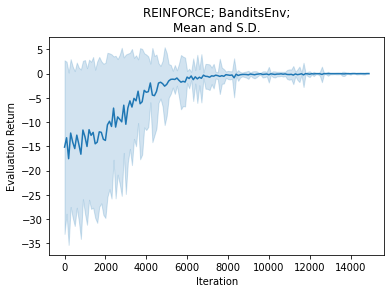

In [8]:
sns.lineplot(x=list(range(0,NUM_ITERATIONS,EVALUATION_PERIOD))*performance.shape[0], y=performance.flatten(),ci='sd')
plt.title('REINFORCE; BanditsEnv;\nMean and S.D.')
plt.xlabel('Iteration')
plt.ylabel('Evaluation Return')

# HW3-P2 "REINFORCE" on LunarLandar-v2

In [9]:
NUM_ITERATIONS = 60000
NUM_EVALUATION_ROLLOUTS = 100
EVALUATION_PERIOD = 100

GAMMA = 0.99

LEARNING_RATE = .0001

In [10]:
random.seed(17)
np.random.seed(17)
torch.manual_seed(17)

env = gym.make('LunarLander-v2')
env.action_space.seed(17)
env.seed(17)

[17]

In [11]:
performance = np.zeros((NUM_EVALUATION_ROLLOUTS,math.ceil(NUM_ITERATIONS/EVALUATION_PERIOD)))
pi = Policy(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(pi.parameters(),lr=LEARNING_RATE)

now = datetime.datetime.now()
writer = SummaryWriter("runs/scalar-{}".format(now.strftime("%Y%m%d-%H%M%S")))

# 1 iteration == deploying a fixed stationary stochastic policy in the environment for 1 rollout until 
# termination and then using the collected data from that rollout to perform 1 policy gradient update
for iteration in range(NUM_ITERATIONS):
    history = []
    done = False
    state = env.reset()
    
    while not done: 
        action = pi.act(state)
        next_state, reward, done, info = env.step(action)
        history.append([state, action, reward, next_state, done])
        state = next_state

    # Sweep backwards through the collected data and use sample_return to accumulate the rewards 
    # to form the Monte Carlo estimates of the returns
    sample_return = 0
    loss = 0
    optimizer.zero_grad()
    
    for entry in reversed(history):
        state, action, reward, next_state, done = entry
        sample_return = reward + (GAMMA * sample_return)
        loss -= torch.log(pi(state)[action])*(sample_return) / len(history)
    
    # Take a policy gradient step
    loss.backward()
    optimizer.step()

    # Evaluate current policy occasionaly
    if iteration % EVALUATION_PERIOD == 0:
        evaluation_returns = np.zeros(NUM_EVALUATION_ROLLOUTS)

        for test_index in range(NUM_EVALUATION_ROLLOUTS):
            done = False
            evaluation_return = 0
            state = env.reset()
            while not done:
                action = pi.act(state)
                next_state, reward, done, info = env.step(action)
                state = next_state
                evaluation_return += reward # Instructor response on Piazza post @457 asks to evaluate without discounting.
            evaluation_returns[test_index] = evaluation_return
        writer.add_scalar('Expected Return (Lunar Lander) (Extended Run)', np.mean(evaluation_returns), iteration)                
        writer.flush()
        performance[:,int(iteration/EVALUATION_PERIOD)] = evaluation_returns
        print('Iteration: ', iteration,'\t', 'Evaluation: ', np.mean(evaluation_returns))
        
writer.close()

Iteration:  0 	 Evaluation:  -176.86190060733273
Iteration:  100 	 Evaluation:  -171.44762555085785
Iteration:  200 	 Evaluation:  -181.16247566411587
Iteration:  300 	 Evaluation:  -169.01931309838452
Iteration:  400 	 Evaluation:  -178.23615985440208
Iteration:  500 	 Evaluation:  -172.8039123334216
Iteration:  600 	 Evaluation:  -179.3404127019464
Iteration:  700 	 Evaluation:  -167.53086095941543
Iteration:  800 	 Evaluation:  -183.87469637880469
Iteration:  900 	 Evaluation:  -173.8106614974028
Iteration:  1000 	 Evaluation:  -188.60500030684668
Iteration:  1100 	 Evaluation:  -167.20335774449416
Iteration:  1200 	 Evaluation:  -175.0005548820457
Iteration:  1300 	 Evaluation:  -177.16163130861753
Iteration:  1400 	 Evaluation:  -178.2873764681331
Iteration:  1500 	 Evaluation:  -168.12417769245454
Iteration:  1600 	 Evaluation:  -193.66806731664758
Iteration:  1700 	 Evaluation:  -178.6764924096386
Iteration:  1800 	 Evaluation:  -168.17185878441853
Iteration:  1900 	 Evaluation:

Iteration:  15800 	 Evaluation:  -91.55243478076218
Iteration:  15900 	 Evaluation:  -106.29460156791163
Iteration:  16000 	 Evaluation:  -103.50834038051393
Iteration:  16100 	 Evaluation:  -99.83324268359351
Iteration:  16200 	 Evaluation:  -99.32042818139354
Iteration:  16300 	 Evaluation:  -100.10658202872024
Iteration:  16400 	 Evaluation:  -94.42908382999461
Iteration:  16500 	 Evaluation:  -93.13034532459982
Iteration:  16600 	 Evaluation:  -91.18092635051661
Iteration:  16700 	 Evaluation:  -101.52525445372322
Iteration:  16800 	 Evaluation:  -100.94495621618178
Iteration:  16900 	 Evaluation:  -102.83671685633722
Iteration:  17000 	 Evaluation:  -120.85327125915884
Iteration:  17100 	 Evaluation:  -90.10863101690722
Iteration:  17200 	 Evaluation:  -95.6685664490043
Iteration:  17300 	 Evaluation:  -100.5003578652879
Iteration:  17400 	 Evaluation:  -97.65211290976384
Iteration:  17500 	 Evaluation:  -100.37783405860182
Iteration:  17600 	 Evaluation:  -84.33714103143484
Itera

Iteration:  31500 	 Evaluation:  -3.8350973416221823
Iteration:  31600 	 Evaluation:  -6.7062122209905874
Iteration:  31700 	 Evaluation:  5.692571846868498
Iteration:  31800 	 Evaluation:  -10.618673439796014
Iteration:  31900 	 Evaluation:  0.8510799069185677
Iteration:  32000 	 Evaluation:  6.007433218678338
Iteration:  32100 	 Evaluation:  -2.982237885817782
Iteration:  32200 	 Evaluation:  5.606309347101845
Iteration:  32300 	 Evaluation:  -3.415674200517957
Iteration:  32400 	 Evaluation:  -0.29337694202557735
Iteration:  32500 	 Evaluation:  0.3826698885007329
Iteration:  32600 	 Evaluation:  -3.5673303604635316
Iteration:  32700 	 Evaluation:  12.88884849460249
Iteration:  32800 	 Evaluation:  11.102214984060849
Iteration:  32900 	 Evaluation:  8.049093880637363
Iteration:  33000 	 Evaluation:  14.195393432547773
Iteration:  33100 	 Evaluation:  1.0094530340401153
Iteration:  33200 	 Evaluation:  7.950471777242057
Iteration:  33300 	 Evaluation:  5.492847415201536
Iteration:  3

Iteration:  47500 	 Evaluation:  117.55875917445518
Iteration:  47600 	 Evaluation:  108.07422473282014
Iteration:  47700 	 Evaluation:  118.06381893530002
Iteration:  47800 	 Evaluation:  118.28101678252064
Iteration:  47900 	 Evaluation:  115.60684382087491
Iteration:  48000 	 Evaluation:  123.95071617539648
Iteration:  48100 	 Evaluation:  120.7834811629914
Iteration:  48200 	 Evaluation:  124.37335606520317
Iteration:  48300 	 Evaluation:  120.43100767075562
Iteration:  48400 	 Evaluation:  119.19335729101464
Iteration:  48500 	 Evaluation:  116.6139600489414
Iteration:  48600 	 Evaluation:  117.3198311422087
Iteration:  48700 	 Evaluation:  122.47090446564653
Iteration:  48800 	 Evaluation:  119.87852725782928
Iteration:  48900 	 Evaluation:  115.96001211401172
Iteration:  49000 	 Evaluation:  120.7992326228367
Iteration:  49100 	 Evaluation:  125.52958028354782
Iteration:  49200 	 Evaluation:  125.3006023332274
Iteration:  49300 	 Evaluation:  123.61073244663805
Iteration:  49400

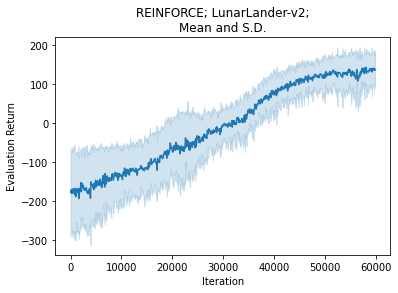

In [22]:
sns.lineplot(x=list(range(0,NUM_ITERATIONS,EVALUATION_PERIOD))*performance.shape[0], y=performance.flatten(),ci='sd')
plt.title('REINFORCE; LunarLander-v2;\nMean and S.D.')
plt.xlabel('Iteration')
plt.ylabel('Evaluation Return')
plt.savefig('REINFORCE_LL.png',dpi=300)

# HW3-P2 "REINFORCE with Value-Function Baseline" on BanditEnv

In [ ]:
NUM_ITERATIONS = 15000
NUM_EVALUATION_ROLLOUTS = 100
EVALUATION_PERIOD = 100

GAMMA = 0.99

LEARNING_RATE = .0001
LEARNING_RATE_V = .0001

In [ ]:
random.seed(17)
np.random.seed(17)
torch.manual_seed(17)

env = BanditEnv()
env.action_space.seed(17)
env.seed(17)

In [ ]:
performance_b = np.zeros((NUM_EVALUATION_ROLLOUTS,math.ceil(NUM_ITERATIONS/EVALUATION_PERIOD)))

pi_b = Policy(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(pi_b.parameters(),lr=LEARNING_RATE)
v = ValueFunction(env.observation_space.shape[0])
optimizer_v = optim.Adam(v.parameters(),lr=LEARNING_RATE_V)

now = datetime.datetime.now()
writer = SummaryWriter("runs/scalar-{}".format(now.strftime("%Y%m%d-%H%M%S")))

# 1 iteration == deploying a fixed stationary stochastic policy in the environment for 1 rollout until 
# termination and then using the collected data from that rollout to perform 1 policy gradient update
for iteration in range(NUM_ITERATIONS):
    history = []
    done = False
    state = env.reset()
    
    while not done: 
        action = pi_b.act(state)
        next_state, reward, done, info = env.step(action)
        history.append([state, action, reward, next_state, done])
        state = next_state

    # Sweep backwards through the collected data and use sample_return to accumulate the rewards 
    # to form the Monte Carlo estimates of the returns
    sample_return = 0
    loss = 0
    optimizer.zero_grad()

    # Update Value-function first 
    for entry in reversed(history):
        state, action, reward, next_state, done = entry
        sample_return = reward + (GAMMA * sample_return)
        optimizer_v.zero_grad()   
        loss_v = (sample_return - v(state))**2
        loss_v.backward()
        optimizer_v.step()                                  

    # Calculate loss with value function baseline
    for entry in reversed(history):
        state, action, reward, next_state, done = entry
        sample_return = reward + (GAMMA * sample_return)
        loss -= torch.log(pi_b(state)[action])*(sample_return - v(state)) / len(history)
    
    # Take a policy gradient step
    loss.backward()
    optimizer.step()

    # Evaluate current policy occasionaly
    if iteration % EVALUATION_PERIOD == 0:
        evaluation_returns = np.zeros(NUM_EVALUATION_ROLLOUTS)

        for test_index in range(NUM_EVALUATION_ROLLOUTS):
            done = False
            evaluation_return = 0
            state = env.reset()
            while not done:
                action = pi_b.act(state)
                next_state, reward, done, info = env.step(action)
                state = next_state
                evaluation_return += reward # Instructor response on Piazza post @457 asks to evaluate without discounting.
            evaluation_returns[test_index] = evaluation_return
        writer.add_scalar('Expected Return (BanditEnv; RwB)', np.mean(evaluation_returns), iteration)                
        writer.flush()
        performance_b[:,int(iteration/EVALUATION_PERIOD)] = evaluation_returns
        print('Iteration: ', iteration,'\t', 'Evaluation: ', np.mean(evaluation_returns))
writer.close()        

In [ ]:
sns.lineplot(x=list(range(0,NUM_ITERATIONS,EVALUATION_PERIOD))*performance_b.shape[0], y=performance_b.flatten(),ci='sd')
plt.title('RwB; BanditsEnv;\nMean and S.D.')
plt.xlabel('Iteration')
plt.ylabel('Evaluation Return')

# HW3-P2 "REINFORCE with Value-Function Baseline" on LunarLander-v2

In [ ]:
NUM_ITERATIONS = 60000
NUM_EVALUATION_ROLLOUTS = 100
EVALUATION_PERIOD = 100

GAMMA = 0.99

LEARNING_RATE = .0001
LEARNING_RATE_V = .0001

In [ ]:
random.seed(17)
np.random.seed(17)
torch.manual_seed(17)

env = gym.make('LunarLander-v2')
env.action_space.seed(17)
env.seed(17)

In [ ]:
performance_b = np.zeros((NUM_EVALUATION_ROLLOUTS,math.ceil(NUM_ITERATIONS/EVALUATION_PERIOD)))

pi_b = Policy(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(pi_b.parameters(),lr=LEARNING_RATE)
v = ValueFunction(env.observation_space.shape[0])
optimizer_v = optim.Adam(v.parameters(),lr=LEARNING_RATE_V)

now = datetime.datetime.now()
writer = SummaryWriter("runs/scalar-{}".format(now.strftime("%Y%m%d-%H%M%S")))

# 1 iteration == deploying a fixed stationary stochastic policy in the environment for 1 rollout until 
# termination and then using the collected data from that rollout to perform 1 policy gradient update
for iteration in range(NUM_ITERATIONS):
    history = []
    done = False
    state = env.reset()
    
    while not done: 
        action = pi_b.act(state)
        next_state, reward, done, info = env.step(action)
        history.append([state, action, reward, next_state, done])
        state = next_state

    # Sweep backwards through the collected data and use sample_return to accumulate the rewards 
    # to form the Monte Carlo estimates of the returns
    sample_return = 0
    loss = 0
    optimizer.zero_grad()

    for entry in reversed(history):
        state, action, reward, next_state, done = entry
        sample_return = reward + (GAMMA * sample_return)
        loss_v += (sample_return - v(state))**2
    loss_v.backward()
    optimizer_v.step()                                  
    
    for entry in reversed(history):
        state, action, reward, next_state, done = entry
        sample_return = reward + (GAMMA * sample_return)
        loss -= torch.log(pi_b(state)[action])*(sample_return - v(state)) / len(history)
    
    # Take a policy gradient step
    loss.backward()
    optimizer.step()

    # Evaluate current policy occasionaly
    if iteration % EVALUATION_PERIOD == 0:
        evaluation_returns = np.zeros(NUM_EVALUATION_ROLLOUTS)

        for test_index in range(NUM_EVALUATION_ROLLOUTS):
            done = False
            evaluation_return = 0
            state = env.reset()
            while not done:
                action = pi_b.act(state)
                next_state, reward, done, info = env.step(action)
                state = next_state
                evaluation_return += reward # Instructor response on Piazza post @457 asks to evaluate without discounting.
            evaluation_returns[test_index] = evaluation_return
        writer.add_scalar('Expected Return (Lunar Lander; RwB)', np.mean(evaluation_returns), iteration)                
        writer.flush()
        performance_b[:,int(iteration/EVALUATION_PERIOD)] = evaluation_returns
        print('Iteration: ', iteration,'\t', 'Evaluation: ', np.mean(evaluation_returns))
writer.close()        

In [ ]:
sns.lineplot(x=list(range(0,NUM_ITERATIONS,EVALUATION_PERIOD))*performance_b.shape[0], y=performance_b.flatten(),ci='sd')
plt.title('RwB; LunarLander-v2;\nMean and S.D.')
plt.xlabel('Iteration')
plt.ylabel('Evaluation Return')